## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflo

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [14]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25,0.75]
redice_lr_patient = [5,10]

In [15]:
import itertools

for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print(i,end=' ')
    print(optim, reduce_factor, reduce_patient)

0 <keras.optimizers.SGD object at 0x00000168B0C92088> 0.25 5
1 <keras.optimizers.SGD object at 0x00000168B0C92088> 0.25 10
2 <keras.optimizers.SGD object at 0x00000168B0C92088> 0.75 5
3 <keras.optimizers.SGD object at 0x00000168B0C92088> 0.75 10
4 <keras.optimizers.Adam object at 0x00000168B0F49C88> 0.25 5
5 <keras.optimizers.Adam object at 0x00000168B0F49C88> 0.25 10
6 <keras.optimizers.Adam object at 0x00000168B0F49C88> 0.75 5
7 <keras.optimizers.Adam object at 0x00000168B0F49C88> 0.75 10
8 <keras.optimizers.RMSprop object at 0x00000168B0CA3F48> 0.25 5
9 <keras.optimizers.RMSprop object at 0x00000168B0CA3F48> 0.25 10
10 <keras.optimizers.RMSprop object at 0x00000168B0CA3F48> 0.75 5
11 <keras.optimizers.RMSprop object at 0x00000168B0CA3F48> 0.75 10


In [19]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, min_lr=1e-12, monitor='val_loss', patience=reduce_patient, verbose=1)
    
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), shuffle=True,callbacks=[reduce_lr])

    # Collect results
    if(i<4):
        optmizer_name='SGD'
    elif(i<8):
        optmizer_name='Adam'
    else:
        optmizer_name='RMSprop'
    exp_name_tag = ("#-%s " % (i))+optmizer_name+' r_f:'+str(reduce_factor)+' patc:'+str(reduce_patient)
    
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3098 - accuracy: 0.5438 - val_loss: 1.4906 - val_accuracy: 0.4723
Epoch 12/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2850 - accuracy: 0.5539 - val_loss: 1.4744 - val_accuracy: 0.4790
Epoch 13/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2632 - accuracy: 0.5598 - val_loss: 1.4661 - val_accuracy: 0.4808
Epoch 14/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2422 - accuracy: 0.5682 - val_loss: 1.4643 - val_accuracy: 0.4869
Epoch 15/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2212 - accuracy: 0.5767 - val_loss: 1.4659 - val_accuracy: 0.4838
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2010 - accuracy: 0.5838 - val_loss: 1.4697 - val_accuracy: 0.4833
Epoch 17/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1820 - accuracy: 0.5901 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.2543 - accuracy: 0.2616 - val_loss: 2.1626 - val_accuracy: 0.1972
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7639 - accuracy: 0.3845 - val_loss: 2.0021 - val_accuracy: 0.2852
Epoch 3/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6403 - accuracy: 0.4255 - val_loss: 1.8617 - val_accuracy: 0.3371
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5667 - accuracy: 0.4506 - val_loss: 1.7392 - val_accuracy: 0.3855
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5111 - accuracy: 0.4701 - val_loss: 1.6384 - val_accuracy: 0.4194
Epoch 6/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4672 - accuracy: 0.4856 - val_loss: 1.5937 - val_accuracy: 0.4292
Epoch 7/25
50000/50000 [==============================] - 2s 36us/st

50000/50000 [==============================] - 2s 37us/step - loss: 0.5637 - accuracy: 0.8268 - val_loss: 1.3859 - val_accuracy: 0.5440
Epoch 21/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.5506 - accuracy: 0.8337 - val_loss: 1.3923 - val_accuracy: 0.5437
Epoch 22/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.5404 - accuracy: 0.8382 - val_loss: 1.4054 - val_accuracy: 0.5433
Epoch 23/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.5350 - accuracy: 0.8396 - val_loss: 1.4170 - val_accuracy: 0.5396
Epoch 24/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.5280 - accuracy: 0.8425 - val_loss: 1.4159 - val_accuracy: 0.5426

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 0.5125 - accuracy: 0.8500 - val_loss: 1.4104 - val_accuracy: 0.5443
Numbers of exp: 5, reduce_factor: 0.25, re

50000/50000 [==============================] - 2s 37us/step - loss: 1.5996 - accuracy: 0.4417 - val_loss: 1.7610 - val_accuracy: 0.3829
Epoch 5/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.5559 - accuracy: 0.4564 - val_loss: 1.6876 - val_accuracy: 0.4076
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5198 - accuracy: 0.4689 - val_loss: 1.6312 - val_accuracy: 0.4268
Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4911 - accuracy: 0.4789 - val_loss: 1.6125 - val_accuracy: 0.4321
Epoch 8/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4661 - accuracy: 0.4863 - val_loss: 1.5878 - val_accuracy: 0.4443
Epoch 9/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4440 - accuracy: 0.4954 - val_loss: 1.5727 - val_accuracy: 0.4459
Epoch 10/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4239 - accuracy: 0.5023 - val_loss: 1.5582 - va

50000/50000 [==============================] - 2s 36us/step - loss: 1.2657 - accuracy: 0.5639 - val_loss: 1.5087 - val_accuracy: 0.4717
Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2575 - accuracy: 0.5674 - val_loss: 1.5033 - val_accuracy: 0.4729
Numbers of exp: 8, reduce_factor: 0.25, reduce_patient: 5
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
______________________________________________

50000/50000 [==============================] - 2s 36us/step - loss: 1.7330 - accuracy: 0.3995 - val_loss: 1.7649 - val_accuracy: 0.3773
Epoch 8/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6957 - accuracy: 0.4114 - val_loss: 1.7472 - val_accuracy: 0.3890
Epoch 9/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6622 - accuracy: 0.4193 - val_loss: 1.7248 - val_accuracy: 0.3958
Epoch 10/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6337 - accuracy: 0.4310 - val_loss: 1.7024 - val_accuracy: 0.4050
Epoch 11/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6084 - accuracy: 0.4380 - val_loss: 1.6902 - val_accuracy: 0.4129
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5853 - accuracy: 0.4458 - val_loss: 1.6813 - val_accuracy: 0.4128
Epoch 13/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5627 - accuracy: 0.4540 - val_loss: 1.6727 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 62us/step - loss: 2.5394 - accuracy: 0.1899 - val_loss: 2.2319 - val_accuracy: 0.1819
Epoch 2/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.1630 - accuracy: 0.2760 - val_loss: 2.1551 - val_accuracy: 0.2079
Epoch 3/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.0037 - accuracy: 0.3182 - val_loss: 2.0550 - val_accuracy: 0.2526
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.8999 - accuracy: 0.3484 - val_loss: 1.9452 - val_accuracy: 0.2985
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.8262 - accuracy: 0.3691 - val_loss: 1.8551 - val_accuracy: 0.3339
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.7689 - accuracy: 0.3855 - val_loss: 1.7977 - val_accuracy: 0.3574
Epoch 7/25
50000/50000 [==============================] - 2s 36us/st

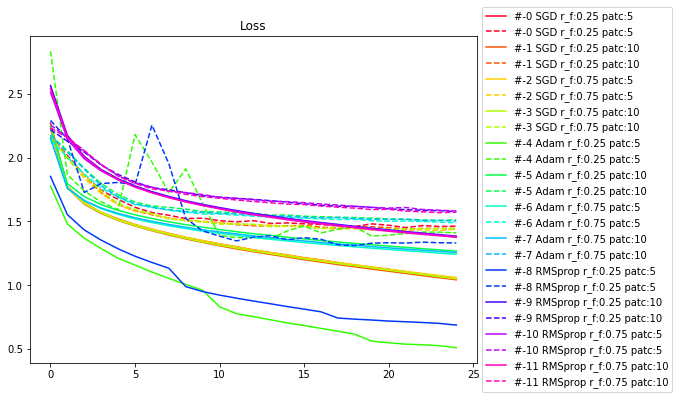

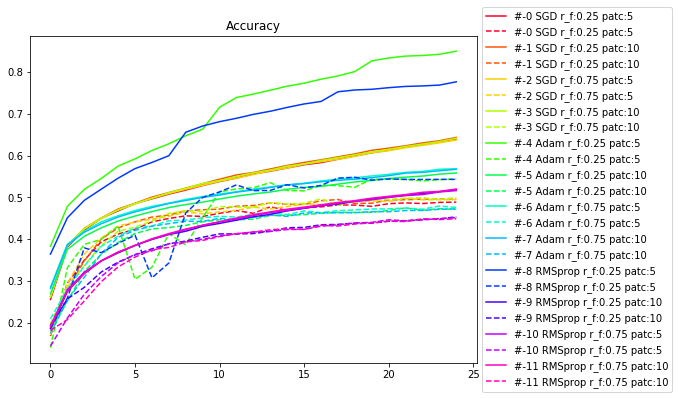

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()